# 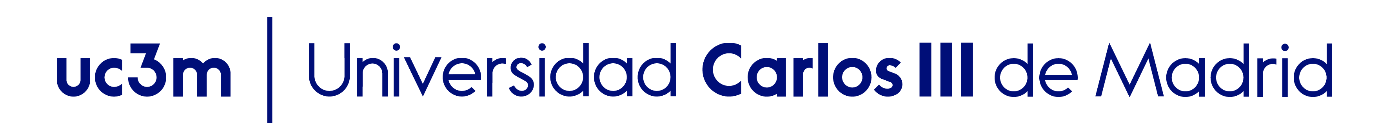
**ASSIGNMENT #1:PREDICTING BANK PRODUCT SUBSCRIPTION**

**Students:** Javier Rodríguez Márquez, Marcos Santiago Soto
**NIA:** 100498243,





---


## Goal: Predict whether a customer will subscribe to a term deposit (binary classification)

**Dataset**: `bank_24.pkl`  
**Target Variable**: `deposit` (yes/no)  
**Records**: 11,000 samples, 17 features

---

## **Project Workflow Index**

Following the assignment guidelines, this notebook follows the required structure:

---

### **1. Simplified EDA (0.5 points)**
- Determine number of features and instances
- Identify categorical vs numerical variables
- Identify high cardinality categorical variables
- Check for missing values
- Identify constant columns
- Determine if classification or regression problem
- Check for class imbalance
- **Special analysis of `pdays` variable and preprocessing justification**

### **2. Basic Methods: Trees, KNN, and Logistic Regression (1 point)**
- Decision Trees
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Model training with Holdout (train/test)
- Preprocessing using pipelines
- Execution time reporting

### **3. Hyperparameter Optimization/Tuning (1 point)**
- Grid Search or Random Search
- Cross-validation for hyperparameter selection
- Best parameters identification

### **4. Advanced Methods (1.5 points)**
- Random Forest
- Gradient Boosting (XGBoost, LightGBM, etc.)
- Support Vector Machines or other advanced models
- Ensemble methods

### **5. Results and Final Model (0.5 points)**
- Model comparison (Accuracy as main metric)
- Confidence intervals for Accuracy
- Final model selection and justification
- Predictions on competition dataset

---

**Note:** Seed set to Student ID (NIA: 100498243) for reproducibility

## 1. Import Libraries and lead dataset

Import all necessary packages for data analysis and machine learning.

In [ ]:
# Data handling
import pickle
import pandas as pd
import numpy as np
import os, random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib

# Reproducibility seed
SEED = 100498243
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Visualization settings (robust to seaborn version)
try:
    sns.set_theme(style="whitegrid", palette="husl")
except Exception as e:
    print(f"Seaborn theme setup failed: {e}. Falling back to basic style.")
    plt.style.use('seaborn')

pd.set_option('display.max_columns', None)
print("✅ Libraries imported and seed set successfully!")

ModuleNotFoundError: No module named 'seaborn'

In [4]:
# Reproducibility seed
import os, random
SEED = 100498243
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Seed set to {SEED}")

Seed set to 100498243




We will now load the pickle file containing the bank marketing data.

In [5]:
# Load the dataset from pickle file
with open('bank_24.pkl', 'rb') as f:
    df = pickle.load(f)

print(f"✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

✅ Dataset loaded successfully!
Shape: (11000, 17)

First few rows:


/var/folders/3g/ptl1dg2554nckg52pchggkxw0000gn/T/ipykernel_19243/1194937271.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,None,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 2. Simplified Exploratory Data Analysis (EDA)

We will start with a simplified EDA. The goal is to better understand the database structure and data distribution, addedo to checking for any missing or wrong values.


### EDA Step: Dataset Information
Purpose: Quickly inspect the dataframe structure (column names, dtypes, non-null counts) to confirm loading integrity and spot obvious anomalies (e.g., unexpected object types for numeric fields). Decisions: No transformations applied yet; this step is read-only. If unexpected dtypes appear, they will be flagged for later preprocessing.

In [6]:
# 3.1 Dataset Information
print("="*60)
print("Dataset Information")
print("="*60)
df.info()

Dataset Information
<class 'pandas.core.frame.DataFrame'>
Index: 11000 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11000 non-null  int64 
 1   job        11000 non-null  object
 2   marital    10553 non-null  object
 3   education  11000 non-null  object
 4   default    11000 non-null  object
 5   balance    11000 non-null  int64 
 6   housing    11000 non-null  object
 7   loan       11000 non-null  object
 8   contact    11000 non-null  object
 9   day        11000 non-null  int64 
 10  month      11000 non-null  object
 11  duration   11000 non-null  int64 
 12  campaign   11000 non-null  int64 
 13  pdays      11000 non-null  int64 
 14  previous   11000 non-null  int64 
 15  poutcome   11000 non-null  object
 16  deposit    11000 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.5+ MB


### EDA Step: Missing Values
Purpose: Identify features with missing data to plan imputation or dropping strategies. Approach: Count and percentage table filtered to only columns with >=1 missing. Decision: If no missing values appear, we skip imputation for Simplified EDA.

In [7]:
# 3.2 Check for Missing Values
print("\n" + "="*60)
print("Missing Values")
print("="*60)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)


Missing Values
         Missing Count  Percentage
marital            447    4.063636


### EDA Step: Dataset Dimensions
Purpose: Capture number of rows and columns and list column names to verify expected schema (17 features + target). Decision: If unexpected extra columns appear, mark for review. This also confirms no silent column expansion during loading.

In [ ]:
# 3.3 Dataset Shape and Dimensions
print("\n" + "="*60)
print("Dataset Dimensions")
print("="*60)
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names:\n{list(df.columns)}")

### EDA Step: Numerical Summary
Purpose: Basic descriptive statistics (mean, std, quartiles) for numerical features to spot scale differences, outliers, and potential need for transformation. Decision: No scaling/outlier treatment at Simplified EDA stage; just reconnaissance.

In [8]:
# 3.4 Statistical Summary for Numerical Features
print("\n" + "="*60)
print("Numerical Features - Statistical Summary")
print("="*60)
df.describe()


Numerical Features - Statistical Summary


,age,balance,day,duration,campaign,pdays,previous
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.00000,11000.000000,11000.000000
mean,41.252727,1529.139273,15.660818,372.524909,2.50800,51.308636,0.828000
std,11.940474,3217.396248,8.417970,347.515713,2.72221,108.782842,2.282936
min,18.000000,-6847.000000,1.000000,2.000000,1.00000,-1.000000,0.000000
25%,32.000000,122.750000,8.000000,138.000000,1.00000,-1.000000,0.000000
50%,39.000000,549.500000,15.000000,255.000000,2.00000,-1.000000,0.000000
75%,49.000000,1711.000000,22.000000,498.000000,3.00000,20.250000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.00000,854.000000,58.000000


### EDA Step: Target Variable Distribution (Counts/Percentages)
Purpose: Assess class balance, identify imbalance ratio early for metric interpretation and potential resampling or class-weight strategies later. Decision: Record imbalance ratio now; action deferred until modeling phase.

In [9]:
# 3.5 Target Variable Distribution
print("\n" + "="*60)
print("Target Variable: 'deposit'")
print("="*60)
print(df['deposit'].value_counts())
print(f"\nPercentage distribution:")
print(df['deposit'].value_counts(normalize=True) * 100)


Target Variable: 'deposit'
deposit
no     5780
yes    5220
Name: count, dtype: int64

Percentage distribution:
deposit
no     52.545455
yes    47.454545
Name: proportion, dtype: float64


### EDA Step: Target Variable Visualization
Purpose: Simple bar chart to visually confirm imbalance and potential dominance of one class. Decision: No further plots at this simplified stage (avoid over-analysis early).

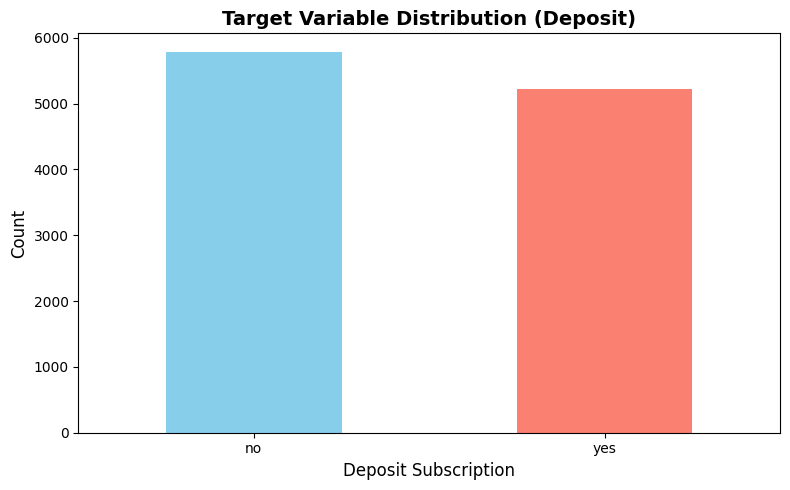

In [10]:
# 3.6 Visualize Target Variable Distribution
plt.figure(figsize=(8, 5))
df['deposit'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Variable Distribution (Deposit)', fontsize=14, fontweight='bold')
plt.xlabel('Deposit Subscription', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### EDA Step: Feature Type Breakdown
Purpose: Separate numerical vs categorical features to guide preprocessing (encoding vs scaling). Decision: Threshold-based high-cardinality handling will be noted; no encoding yet at this stage.

In [11]:
# 3.7 Data Types Distribution
print("\n" + "="*60)
print("Feature Types")
print("="*60)
print(f"Total features: {df.shape[1]}")
print(f"Numerical features: {df.select_dtypes(include=['int64', 'float64']).shape[1]}")
print(f"Categorical features: {df.select_dtypes(include=['object']).shape[1]}")
print(f"\nNumerical: {list(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"\nCategorical: {list(df.select_dtypes(include=['object']).columns)}")


Feature Types
Total features: 17
Numerical features: 7
Categorical features: 10

Numerical: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


### EDA Step: High Cardinality & Constant Columns
Purpose: Identify categorical columns with many unique levels (possible need for target/impact encoding later) and constant columns (candidates for removal). Decision: Record only; action deferred until modeling.

In [12]:
# 3.8 High Cardinality & Constant Columns
print("\n" + "="*60)
print("High Cardinality & Constant Columns")
print("="*60)
categorical_cols = df.select_dtypes(include=['object']).columns
cardinality = df[categorical_cols].nunique().sort_values(ascending=False)
cardinality_df = pd.DataFrame({'column': cardinality.index, 'cardinality': cardinality.values})
# Define threshold (can adjust if needed)
CARDINALITY_THRESHOLD = 30
high_card_cols = cardinality_df[cardinality_df['cardinality'] > CARDINALITY_THRESHOLD]['column'].tolist()
constant_cols = [c for c in df.columns if df[c].nunique() == 1]
print(f"Cardinality threshold: > {CARDINALITY_THRESHOLD}")
print(f"High-cardinality categorical columns ({len(high_card_cols)}): {high_card_cols if high_card_cols else 'None'}")
print(f"Constant columns ({len(constant_cols)}): {constant_cols if constant_cols else 'None'}")
print("\nFull categorical cardinality table:")
cardinality_df


High Cardinality & Constant Columns
Cardinality threshold: > 30
High-cardinality categorical columns (0): None
Constant columns (0): None

Full categorical cardinality table:


,column,cardinality
0,job,12
1,month,12
2,education,4
3,poutcome,4
4,marital,3
5,contact,3
6,default,2
7,housing,2
8,loan,2
9,deposit,2


### EDA Step: pdays Simplified Handling
Purpose: Convert raw `pdays` into two clearer signals: (1) `pdays_contacted` indicates whether the client had prior contact (pdays != -1), (2) `pdays_clean` is the numeric gap with `NaN` where no prior contact exists. Decision: No capping, transformation, or encoding at this stage; sentinel -1 is treated as structural absence. All statistics will use `pdays_clean` filtered to non-null values.

In [15]:
# 3.10 Simple pdays preprocessing: add boolean flag and clean version
print("\n" + "="*60)
print("pdays simple preprocessing: contacted flag + cleaned column")
print("="*60)
if 'pdays' in df.columns:
    df['pdays_contacted'] = (df['pdays'] != -1)
    df['pdays_clean'] = df['pdays'].where(df['pdays'] != -1, np.nan)
    print("Added columns: pdays_contacted (bool), pdays_clean (NaN for -1)")
    print("Value counts for pdays_contacted:")
    print(df['pdays_contacted'].value_counts(dropna=False))
    print("\nBasic stats for pdays_clean (excluding NaN):")
    print(df['pdays_clean'].describe())
else:
    print("Column 'pdays' not found in dataset.")


pdays simple preprocessing: contacted flag
Added 'pdays_contacted' column. Value counts:
pdays_contacted
False    8203
True     2797
Name: count, dtype: int64
